<a href="https://colab.research.google.com/github/furahadamien/fradaX/blob/master/mlp.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Epoch 4
Train accuracy: 0.09965
Val accuracy: 0.1014


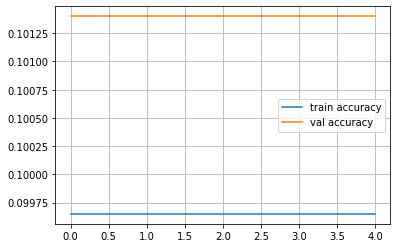

 15%|█▌        | 188/1250 [00:01<00:07, 149.09it/s]

In [0]:
from __future__ import print_function
import numpy as np ## For numerical python
import keras
import matplotlib.pyplot as plt
from tqdm import trange
from IPython.display import clear_output
import torch
import torchvision
import torchvision.transforms as transforms
np.random.seed(42)

#class to allow for forward pass and back pass
class Layer:
  def __init__(self):
    pass

  def forward(self, input):
    return input
  
  def backward(self, input, grad_output):
    num_units = input.shape[1]
        
    d_layer_d_input = np.eye(num_units)
        
    return np.dot(grad_output, d_layer_d_input)

#Non-Linearlity activation function
class ReLU(Layer):
  def __init__(self):
    pass

  def forward(self, input):
    relu_forward = np.maximum(0,input)
    return relu_forward
  
  def backward(self, input, grad_output):
    relu_grad = input > 0
    return grad_output*relu_grad

class Dense(Layer):
  def __init__(self, input_units, output_units, learning_rate=0.1):
    self.learning_rate = learning_rate
    self.weights = np.random.normal(loc=0.0, 
      scale = np.sqrt(2/(input_units+output_units)), 
      size = (input_units,output_units))
    self.biases = np.zeros(output_units)
  
  def forward(self,input):
    return np.dot(input,self.weights) + self.biases
  
  def backward(self,input,grad_output):
    grad_input = np.dot(grad_output, self.weights.T)
    grad_weights = np.dot(input.T, grad_output)
    grad_biases = grad_output.mean(axis=0)*input.shape[0]
    assert grad_weights.shape == self.weights.shape and grad_biases.shape == self.biases.shape

    #Stochastic Gradient Descent
    self.weights = self.weights - self.learning_rate * grad_weights
    self.biases = self.biases - self.learning_rate * grad_biases
    return grad_input

def softmax_crossentropy_with_logits(logits,reference_answers):
  logits_for_answers = logits[np.arange(len(logits)),reference_answers]
  xentropy = - logits_for_answers + np.log(np.sum(np.exp(logits),axis=-1))
  return xentropy

def grad_softmax_crossentropy_with_logits(logits,reference_answers):
  ones_for_answers = np.zeros_like(logits)
  ones_for_answers[np.arange(len(logits)),reference_answers] = 1
  softmax = np.exp(logits) / np.exp(logits).sum(axis=-1,keepdims=True)
  return (- ones_for_answers + softmax) / logits.shape[0]


%matplotlib inline
#loading dataset
def load_dataset(flatten=False):
    (X_train, y_train), (X_test, y_test) = keras.datasets.cifar10.load_data()


    # normalize x
    X_train = X_train.astype(float) / 255.
    X_test = X_test.astype(float) / 255.

    # we reserve the last 10000 training examples for validation
    X_train, X_val = X_train[:-10000], X_train[-10000:]
    y_train, y_val = y_train[:-10000], y_train[-10000:]

    if flatten:
        X_train = X_train.reshape([X_train.shape[0], -1])
        X_val = X_val.reshape([X_val.shape[0], -1])
        X_test = X_test.reshape([X_test.shape[0], -1])

    return X_train, y_train, X_val, y_val, X_test, y_test

X_train, y_train, X_val, y_val, X_test, y_test = load_dataset(flatten=True)
## Let's look at some example

"""
plt.figure(figsize=[6,6])
X_train = X_train.reshape(10000,3072)
fig, axes1 = plt.subplots(5,5,figsize=(3,3))
for j in range(5):
    for k in range(5):
        i = np.random.choice(range(len(X_train)))
        axes1[j][k].set_axis_off()
        axes1[j][k].imshow(X_train[i:i+1][0])

trainloader = torch.utils.data.DataLoader(X_train, 
    batch_size=4, shuffle=True, num_workers=2)
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(4)))
"""
#defining a network as a list of layers
network = []
network.append(Dense(X_train.shape[1],100))
network.append(ReLU())
network.append(Dense(100,200))
network.append(ReLU())
network.append(Dense(200,10))

def forward(network, X):
  #print("lenths")
  #print(len(X))
  activations = []
  input = X

  for l in network:
    activations.append(l.forward(input))
    input = activations[-1]
    #print("lengths are : ")
    #print(len(activations))
    #print(len(network))
  assert len(activations) == len(network)
  return activations

def predict(network,X):
  logits = forward(network,X)[-1]
  return logits.argmax(axis=-1)

def train(network,X,y):
  layer_activations = forward(network,X)
  layer_inputs = [X]+layer_activations 
  logits = layer_activations[-1]

  loss = softmax_crossentropy_with_logits(logits,y)
  loss_grad = grad_softmax_crossentropy_with_logits(logits,y)

  for layer_index in range(len(network))[::-1]:
    layer = network[layer_index]
    loss_grad = layer.backward(layer_inputs[layer_index],loss_grad)

  return np.mean(loss)

#Training the network
#we are using the mini-batch stochastic grandient descent method
#we split data in to mini-batches and feed them into the network while updating weights
def iterate_minibatches(inputs, targets, batchsize, shuffle=False):
  assert len(inputs) == len(targets)
  if shuffle:
    indices = np.random.permutation(len(inputs))
    for start_idx in trange(0, len(inputs) - batchsize + 1, batchsize):
      if shuffle:
        excerpt = indices[start_idx:start_idx + batchsize]
      else:
        excerpt = slice(start_idx, start_idx + batchsize)
      yield inputs[excerpt], targets[excerpt]
train_log = []
val_log = []

for epoch in range(25):

    for x_batch,y_batch in iterate_minibatches(X_train,y_train,batchsize=32,shuffle=True):
        train(network,x_batch,y_batch)
    
    train_log.append(np.mean(predict(network,X_train)==y_train))
    val_log.append(np.mean(predict(network,X_val)==y_val))
    
    clear_output()
    print("Epoch",epoch)
    print("Train accuracy:",train_log[-1])
    print("Val accuracy:",val_log[-1])
    plt.plot(train_log,label='train accuracy')
    plt.plot(val_log,label='val accuracy')
    plt.legend(loc='best')
    plt.grid()
    plt.show()

  